In [2]:
import os
import sys
from dateutil import parser
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.db import psql_connection

conn = psql_connection()
cursor = conn.cursor()

%matplotlib inline

### Top 10 Events

In [18]:
query = """
    SELECT type, COUNT(type) AS type_count
    FROM events
    GROUP BY type
    ORDER BY type_count DESC
    LIMIT 10;
"""
pd.read_sql_query(query, conn)

,type,type_count
0,Slide start,279962
1,Client error,160009
2,App Became Active,132801
3,View player page,110663
4,Land on Homepage,59170
5,Editor Opened,55485
6,Click Link,51527
7,Land on Pricing Page,25303
8,Display Limit Notification,17722
9,Deck Created,13802


### Top 25 Users with the most decks

In [20]:
query = """
    SELECT 
        users.email, 
        users.signup_at, 
        users.is_paying, 
        users.vertical,
        d.deck_count
    FROM users
    INNER JOIN (
        SELECT distinct_id, count(distinct_id) AS deck_count
        FROM events
        WHERE type = 'Deck Created'
        GROUP BY distinct_id
        ORDER BY deck_count DESC
        LIMIT 25
    ) AS d
    ON d.distinct_id = users.distinct_id;
"""

pd.read_sql_query(query, conn)

,email,signup_at,is_paying,vertical,deck_count
0,jbrittin@hammontonps.org,2017-06-01,True,educator,105
1,katherine.cherry@acps.k12.va.us,None,True,educator,47
2,haiku.claseiv@colegio-estudio.com,2017-06-19,True,educator,41
3,webbcubs@yahoo.com,2016-06-22,True,educator,38
4,adresseokoni6@gmail.com,2017-05-30,True,other,31
5,jose_cerda2@sbcglobal.net,None,False,None,30
6,drimnaghcastle.ias@gmail.com,None,False,None,24
7,DocMRich@aol.com,None,True,educator,22
8,adamt@tratt.com,2017-04-13,True,hr,22
9,associado.lucas@gmail.com,2017-06-06,True,student,21


### Visualizing Deck sizes

In [54]:
query = """
    SELECT 
        u.is_paying,
        d.deck_count
    FROM users AS u
    INNER JOIN (
        SELECT distinct_id, count(distinct_id) AS deck_count
        FROM events
        WHERE type = 'Deck Created'
        GROUP BY distinct_id
    ) AS d
    ON d.distinct_id = u.distinct_id;
    
"""
df = pd.read_sql_query(query, conn)
df.head()

,is_paying,deck_count
0,False,1
1,False,1
2,False,1
3,False,1
4,False,2


In [41]:
paying_df = df[df['is_paying'] == True]
not_paying_df = df[df['is_paying'] == False]

def log_deck_count(deck_count):
    return np.log(deck_count + 1)

for payment_df in [paying_df, not_paying_df]:
    payment_df['log_deck_count'] = payment_df['deck_count'].apply(log_deck_count)

/Users/timwhite/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


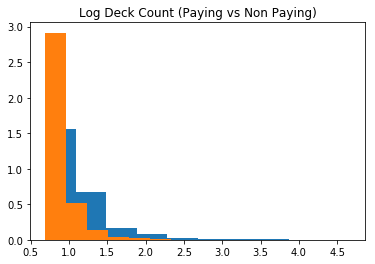

In [53]:
fig, ax = plt.subplots()
ax.hist(paying_df['log_deck_count'], normed=True)
ax.hist(not_paying_df['log_deck_count'], normed=True)
ax.set(title="Log Deck Count (Paying vs Non Paying)")
fig.show()

### Top events of paying and non-paying users

In [67]:
paying_events_query = """
SELECT 
    type AS event_type,
    count(type) AS event_count
FROM events AS e
INNER JOIN (
    SELECT distinct_id
    FROM users
    WHERE is_paying = TRUE
) AS d
ON d.distinct_id = e.distinct_id
GROUP BY type
ORDER BY event_count DESC;
"""

non_paying_query = """
    SELECT 
        type AS event_type,
        count(type) AS event_count
    FROM events AS e
    INNER JOIN (
        SELECT distinct_id
        FROM users
        WHERE is_paying = FALSE
    ) AS d
    ON d.distinct_id = e.distinct_id
    GROUP BY type
    ORDER BY event_count DESC;
"""
paying_df = pd.read_sql_query(paying_events_query, conn)
non_paying_df = pd.read_sql_query(non_paying_query, conn)

In [68]:
paying_df.head(10)

,event_type,event_count
0,Client error,17642
1,Slide start,8318
2,Editor Opened,8172
3,Click Link,5602
4,View player page,3582
5,signin,3446
6,App Became Active,3322
7,Export PPT,2512
8,Land on Homepage,2506
9,Export,2164


In [69]:
non_paying_df.head(10)

,event_type,event_count
0,App Became Active,95233
1,Slide start,54395
2,Editor Opened,41284
3,Client error,37785
4,Display Limit Notification,15375
5,Click Link,13810
6,Deck Created,10598
7,signin,8548
8,View player page,7684
9,Sign In,6864


### Events of those who `upgrade`

In [72]:
query = """
    -- Aggregate all events for users who have upgraded
    SELECT type, COUNT(type) AS event_count
    FROM events AS e
    INNER JOIN (
        -- Find all users who have upgraded
        SELECT u.distinct_id
        FROM users AS u
        INNER JOIN (
            -- Find `distinct_id` of upgrade events
            SELECT distinct_id
            FROM events 
            WHERE type = 'upgrade'
        ) AS e
        ON u.distinct_id = e.distinct_id
    ) AS u
    ON u.distinct_id = e.distinct_id
    GROUP BY e.type
    ORDER BY event_count DESC;
"""
df = pd.read_sql_query(query, conn)

In [74]:
df.head(10)

,type,event_count
0,Client error,3967
1,Slide start,2171
2,Click Link,1723
3,Editor Opened,1632
4,App Became Active,914
5,Display Limit Notification,639
6,signin,598
7,Export PPT,564
8,Land on Pricing Page,562
9,Export,466


### Top events of users who have upgraded

In [23]:
query = """
SELECT email, e.type, e.count, up.upgraded_at
FROM users AS u
INNER JOIN (
    SELECT events.distinct_id, max(time) AS upgraded_at
    FROM events
    WHERE type = 'upgrade'
    GROUP BY events.distinct_id
) AS up
ON up.distinct_id = u.distinct_id
LEFT JOIN (
    SELECT events.type, events.distinct_id, count(events.distinct_id)
    FROM events 
    LEFT JOIN (
        SELECT events.distinct_id, max(time) AS upgraded_at
        FROM events
        WHERE type = 'upgrade'
        GROUP BY events.distinct_id
    ) AS up
    ON up.distinct_id = events.distinct_id
    WHERE events.time < up.upgraded_at
    GROUP BY events.type, events.distinct_id
) AS e
ON e.distinct_id = u.distinct_id;
"""
df = pd.read_sql_query(query, conn)

In [24]:
df.sample(3)

,email,type,count,upgraded_at
3785,rjg@usp.org,Error on payment,1.0,2017-05-04 04:47:32
9506,moz-elina@yandex.ru,View player page,1.0,2017-06-09 14:26:30
4767,h1@sythe.me,Land on Checkout Page,2.0,2017-06-22 15:24:48


In [25]:
grouped = df.groupby('type')
grouped.describe()

count                        \
                                              count       mean        std   
type                                                                        
App Became Active                             105.0  15.123810  29.760808   
Click Button                                  419.0   1.396181   1.243388   
Click Link                                    627.0   5.725678   5.399801   
Client error                                  423.0  14.392435  45.344726   
Countdown Pro Button                            8.0   1.125000   0.353553   
Deck Created                                  421.0   1.304038   0.712279   
Display Limit Modal                           132.0   1.666667   1.660804   
Display Limit Notification                    555.0   4.583784   8.653671   
Display Welcome Countdown                     104.0   1.086538   0.624897   
Display Zuru Upgrade Modal                      6.0   1.000000   0.000000   
Editor Opened                                 537.0   4.955307   7.704782   
Ended Onboarding                              418.0   1.258373   0.742824   
Error on payment                               23.0   1.521739   1.122884   
Error on payment (stripe)                      14.0   2.285714   2.091322   
Error on payment (stripe, reporting to user)   79.0   1.746835   1.471684   
Export                                        250.0   1.796000   2.179308   
Export PPT                                     58.0   2.879310   4.349138   
Export PPTX                                    19.0   2.263158   2.883711   
Land on Checkout Page                         658.0   1.851064   1.450032   
Land on Classroom Page                         34.0   1.352941   0.848612   
Land on Education Page                        108.0   1.527778   1.147597   
Land on Homepage                              383.0   2.456919   2.473440   
Land on Pricing Page                          650.0   3.058462   2.556534   
Land on Zuru Page                             111.0   1.531532   0.922643   
Limit Button                                  132.0   1.189394   0.447769   
Limit Modal Edu Button                         13.0   1.307692   0.630425   
Limit Modal Pro Button                         27.0   1.074074   0.266880   
New Deck                                      226.0   1.123894   0.598260   
Privacy                                       189.0   1.481481   0.902671   
Set Privacy Public                             20.0   1.200000   0.523148   
Set Privacy Restricted                          1.0   2.000000        NaN   
Share                                          98.0   1.846939   1.494678   
Sign In                                       297.0   2.026936   1.955402   
Sign Up                                       322.0   1.006211   0.078688   
Slide start                                   484.0   6.415289   9.801289   
Start                                          68.0   1.323529   0.781143   
Started Onboarding                            439.0   1.271071   0.732081   
Successfully completed classroom upgrade        1.0   1.000000        NaN   
Successfully completed edu signup               4.0   1.000000   0.000000   
Successfully completed edu upgrade              8.0   1.000000   0.000000   
Successfully completed pro signup               7.0   2.142857   3.023716   
Successfully completed pro upgrade              5.0   1.000000   0.000000   
Validation failed                              94.0   1.595745   1.680496   
View player page                              269.0   2.089219   4.665633   
Zuru Upgrade Edu Button                         1.0   1.000000        NaN   
cancel                                         18.0   1.055556   0.235702   
signin                                        448.0   2.397321   2.672788   
signup                                        254.0   1.062992   0.243428   
upgrade                                        21.0   1.333333   0.730297   

                                         

In [26]:
query = """
    SELECT u.distinct_id, e.type, e.count 
    FROM users AS u
    INNER JOIN (
        SELECT email 
        FROM customers
        INNER JOIN (
            SELECT customer_id 
            FROM payment_events
            WHERE type LIKE 'customer.subscription.deleted'
        ) AS pe
        ON pe.customer_id = customers.identifier
    ) AS c
    ON c.email = u.email
    LEFT JOIN (
        SELECT events.type, events.distinct_id, count(events.distinct_id)
        FROM events 
        LEFT JOIN (
            SELECT events.distinct_id, max(time) AS upgraded_at
            FROM events
            WHERE type = 'upgrade'
            GROUP BY events.distinct_id
        ) AS up
        ON up.distinct_id = events.distinct_id
        WHERE events.time > up.upgraded_at
        GROUP BY events.type, events.distinct_id
    ) AS e
    ON e.distinct_id = u.distinct_id
"""
df = pd.read_sql_query(query, conn)

In [29]:
grouped = df.groupby('type')
grouped.describe()

count                        \
                                              count       mean        std   
type                                                                        
App Became Active                              12.0  10.750000   9.401402   
Click Button                                    4.0   2.000000   0.816497   
Click Link                                    224.0   4.116071   5.646135   
Client error                                  162.0  12.679012  29.077889   
Deck Created                                   79.0   1.898734   1.787384   
Display Limit Modal                             3.0   1.000000   0.000000   
Display Limit Notification                     24.0   2.333333   2.914233   
Display Video Editor Modal                      8.0   1.625000   1.060660   
Download PPTX                                   5.0   1.800000   1.095445   
Downloaded Video                                4.0   2.000000   1.154701   
Editor Opened                                 191.0   4.900524   5.577733   
Ended Onboarding                               78.0   1.602564   1.614381   
Error on payment                                1.0   2.000000        NaN   
Error on payment (stripe, reporting to user)    1.0   2.000000        NaN   
Export                                        119.0   2.764706   2.227356   
Export PPT                                    128.0   3.257812   5.763373   
Export PPTX                                     3.0   2.333333   2.309401   
Land on Checkout Page                          15.0   2.000000   2.267787   
Land on Classroom Page                         19.0   1.105263   0.315302   
Land on Education Page                         26.0   1.346154   0.891843   
Land on Homepage                              113.0   2.159292   1.650576   
Land on Pricing Page                           24.0   1.458333   0.832971   
Land on Zuru Page                              14.0   1.714286   0.913874   
Privacy                                        73.0   1.684932   0.998286   
Recorded Audio                                  3.0  55.000000  46.162756   
Set Privacy Public                             24.0   1.291667   0.624094   
Set Privacy Restricted                         17.0   1.588235   1.227743   
Share                                          47.0   1.914894   1.626276   
Sign In                                       126.0   2.063492   1.691135   
Slide start                                   174.0   6.591954  12.553246   
Start                                          14.0   1.500000   1.344504   
Started Onboarding                             80.0   1.625000   1.664027   
Successfully completed edu signup               6.0   1.000000   0.000000   
Successfully completed edu upgrade            145.0   1.000000   0.000000   
Successfully completed pro signup               7.0   1.000000   0.000000   
Successfully completed pro upgrade             79.0   1.000000   0.000000   
Validation failed                               3.0   1.333333   0.577350   
View player page                               59.0   2.423729   2.415492   
cancel                                        205.0   1.019512   0.138655   
signin                                        183.0   2.568306   2.405233   

                                                                               
                                               min    25%   50%    75%    max  
type                                                                           
App Became Active                              1.0   3.00   9.0  13.50   27.0  
Click Button                                   1.0   1.75   2.0   2.25    3.0  
Click Link                                     1.0   1.00   2.0   5.00   64.0  
Client error                                   1.0   2.00   5.0  11.00  270.0  
Deck Created                                   1.0   1.00   1.0   2.00   13.0  
Display Limit Modal                            1.0   1.00   1.0   1.00    1.0  
Display Limit 